# Generate test sets for xAI evaluation

## Preliminaries

In [ ]:
# Mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install packages.
from IPython.display import clear_output
!pip install captum opencv-python xmltodict
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# Imports general.
import sys
import gc
import warnings
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import captum
from captum.attr import *
import random
import cv2
import PIL
from xml.etree import ElementTree
import xmltodict
import collections
import pickle
import glob 

# Import auxilliary files.
path = "/content/drive/MyDrive/Projects/assets/"
sys.path.append(path+"src")
from models import *
from utils import *
from utils_mnist import *
from utils_cmnist import *
from utils_imagenet import *

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2
clear_output()

## Datasets and modeling

### MNIST

In [ ]:
path_mnist_model = path + "models/mnist_lenet"
path_mnist_assets = path + "test_sets/mnist_test_set.npy"
batch_size_test = 512*2

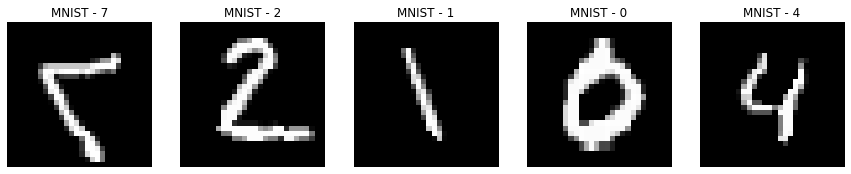


 Model architecture: LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

1024


In [ ]:
# Load datasets and make loaders.
transformer =  transforms.Compose([transforms.RandomAffine(degrees=(0, 10), scale=(0.8, 1.1), interpolation=torchvision.transforms.InterpolationMode.NEAREST), 
                                   transforms.RandomHorizontalFlip(p=0.25), transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(root='./sample_data', train=True, transform=transformer, download=True)
test_set = torchvision.datasets.MNIST(root='./sample_data', train=False, transform=transformer, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True) # num_workers=4,
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, pin_memory=True)

# Load a batch of inputs and outputs to use for evaluation and plot some inputs.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

# Plot examples.
plot_inputs(x_batch=x_batch, y_batch=y_batch, nr_images=5, img_size=28, name_dataset="MNIST")

# Calculate segmentation masks.
s_batch_box =  create_bbox_mnist(x_batch)
s_batch_digit = create_mask_mnist(x_batch)
s_batch_area = create_dilated_mask_mnist(x_batch)

# Save model, x_batch, y_batch, s_batch to one dictionary.
assets = {'x_batch' : x_batch, 
          'y_batch': y_batch,
          's_batch': s_batch_box.reshape(len(x_batch), 1, 28, 28),
          's_batch_box': s_batch_box.reshape(len(x_batch), 1, 28, 28),
          's_batch_digit': s_batch_digit.reshape(len(x_batch), 1, 28, 28),
          's_batch_area':  s_batch_area.reshape(len(x_batch), 1, 28, 28)}

np.save(path_mnist_assets,  assets)   

# Load model architecture.
model = LeNet()
print(f"\n Model architecture: {model.eval()}\n")

# Set necessary configs/ parameters.
if pathlib.Path(path_mnist_model).is_file():
    model.load_state_dict(torch.load(path_mnist_model))
else: 
    model = train_model(model=model.to(device), 
                        train_loader=train_loader, 
                        test_loader=test_loader, 
                        criterion=torch.nn.CrossEntropyLoss(),
                        optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9), 
                        epochs=15,
                        path_model=path_mnist_model, 
                        device=device)

print(len(x_batch))

In [ ]:
model = train_model(model=model.to(device), 
                        train_loader=train_loader, 
                        test_loader=test_loader, 
                        criterion=torch.nn.CrossEntropyLoss(),
                        optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9), 
                        epochs=20,
                        path_model=path_mnist_model, 
                        device=device)

Epoch 1/20 - loss 0.05 - test accuracy: 97.99%
Epoch 2/20 - loss 0.05 - test accuracy: 98.08%
Epoch 3/20 - loss 0.03 - test accuracy: 97.98%
Epoch 4/20 - loss 0.06 - test accuracy: 98.16%
Epoch 5/20 - loss 0.05 - test accuracy: 98.18%
Epoch 6/20 - loss 0.03 - test accuracy: 98.14%
Epoch 7/20 - loss 0.03 - test accuracy: 98.42%
Epoch 8/20 - loss 0.07 - test accuracy: 98.35%
Epoch 9/20 - loss 0.02 - test accuracy: 98.38%
Epoch 10/20 - loss 0.05 - test accuracy: 98.18%
Epoch 11/20 - loss 0.07 - test accuracy: 98.48%
Epoch 12/20 - loss 0.12 - test accuracy: 98.29%
Epoch 13/20 - loss 0.02 - test accuracy: 98.39%
Epoch 14/20 - loss 0.06 - test accuracy: 98.42%
Epoch 15/20 - loss 0.00 - test accuracy: 98.69%
Epoch 16/20 - loss 0.08 - test accuracy: 98.30%
Epoch 17/20 - loss 0.01 - test accuracy: 98.44%
Epoch 18/20 - loss 0.00 - test accuracy: 98.39%
Epoch 19/20 - loss 0.06 - test accuracy: 98.32%
Epoch 20/20 - loss 0.01 - test accuracy: 98.57%


In [ ]:
# Example for how to reload assets and models to notebook.
model_mnist = LeNet()
model_mnist.load_state_dict(torch.load(path_mnist_model))

assets_mnist = np.load(path_mnist_assets, allow_pickle=True).item()
x_batch_mnist = assets_mnist["x_batch"]
y_batch_mnist = assets_mnist["y_batch"]
s_batch_mnist = assets_mnist["s_batch"]

# Visualise segmentation masks
"""
s_batch_box =  create_bbox_mnist(x_batch)
s_batch_digit = create_mask_mnist(x_batch)
s_batch_area = create_dilated_mask_mnist(x_batch)

plt.imshow(x_batch_mnist[0].reshape(28, 28))
plt.show()

plt.imshow(s_batch_box[0].reshape(28, 28))
plt.show()

plt.imshow(s_batch_digit[0].reshape(28, 28))
plt.show()

plt.imshow(s_batch_area[0].reshape(28, 28))
plt.show()
""";

### fMNIST

In [ ]:
path_fmnist_model = path + "models/fmnist_lenet_model"
path_fmnist_assets = path + "test_sets/fmnist_test_set.npy"
batch_size_test = 512*2

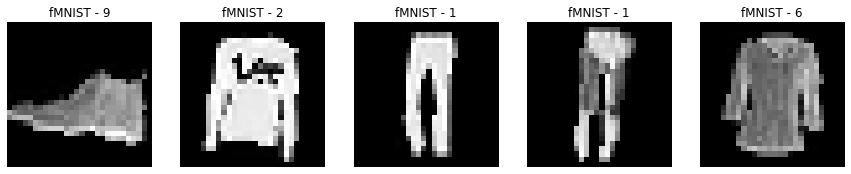


 Model architecture: LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

1024


In [ ]:
# Load datasets and make loaders.
transformer =  transforms.Compose([transforms.RandomAffine(degrees=(0, 10), scale=(0.8, 1.1), interpolation=torchvision.transforms.InterpolationMode.NEAREST), 
                                   transforms.RandomHorizontalFlip(p=0.25), transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST(root='./sample_data', train=True, transform=transformer, download=True)
test_set = torchvision.datasets.FashionMNIST(root='./sample_data', train=False, transform=transformer, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True) # num_workers=4,
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, pin_memory=True)

# Load a batch of inputs and outputs to use for evaluation and plot some inputs.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

# Plot examples.
plot_inputs(x_batch=x_batch, y_batch=y_batch, nr_images=5, img_size=28, name_dataset="fMNIST")

# Calculate segmentation masks.
s_batch = torch.zeros([x_batch.shape[0], 1, x_batch.shape[2], x_batch.shape[3]])

# Calculate segmentation masks.
s_batch_box =  create_bbox_mnist(x_batch)
s_batch_digit = create_mask_mnist(x_batch)
s_batch_area = create_dilated_mask_mnist(x_batch)

# Save model, x_batch, y_batch, s_batch to one dictionary.
assets = {'x_batch' : x_batch, 
          'y_batch': y_batch,
          's_batch': s_batch_box.reshape(len(x_batch), 1, 28, 28),
          's_batch_box': s_batch_box.reshape(len(x_batch), 1, 28, 28),
          's_batch_digit': s_batch_digit.reshape(len(x_batch), 1, 28, 28),
          's_batch_area':  s_batch_area.reshape(len(x_batch), 1, 28, 28)}


np.save(path_fmnist_assets,  assets)

# Load model architecture.
model = LeNet()
print(f"\n Model architecture: {model.eval()}\n")

# Set necessary configs/ parameters.
if pathlib.Path(path_fmnist_model).is_file():
    model.load_state_dict(torch.load(path_mnist_model))
else: 
    model = train_model(model=model.to(device), 
                        train_loader=train_loader, 
                        test_loader=test_loader, 
                        criterion=torch.nn.CrossEntropyLoss(),
                        optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9), 
                        epochs=20,
                        path_model=path_fmnist_model, 
                        device=device)
print(len(x_batch))

In [ ]:
model = train_model(model=model.to(device), 
                        train_loader=train_loader, 
                        test_loader=test_loader, 
                        criterion=torch.nn.CrossEntropyLoss(),
                        optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9), 
                        epochs=20,
                        path_model=path_mnist_model, 
                        device=device)

Epoch 1/20 - loss 0.56 - test accuracy: 80.11%
Epoch 2/20 - loss 0.56 - test accuracy: 81.32%
Epoch 3/20 - loss 0.39 - test accuracy: 84.19%
Epoch 4/20 - loss 0.41 - test accuracy: 84.42%
Epoch 5/20 - loss 0.45 - test accuracy: 84.91%
Epoch 6/20 - loss 0.45 - test accuracy: 85.71%
Epoch 7/20 - loss 0.39 - test accuracy: 85.40%
Epoch 8/20 - loss 0.45 - test accuracy: 85.31%
Epoch 9/20 - loss 0.34 - test accuracy: 85.84%
Epoch 10/20 - loss 0.44 - test accuracy: 86.49%
Epoch 11/20 - loss 0.38 - test accuracy: 86.71%
Epoch 12/20 - loss 0.29 - test accuracy: 86.52%
Epoch 13/20 - loss 0.32 - test accuracy: 86.68%
Epoch 14/20 - loss 0.32 - test accuracy: 87.37%
Epoch 15/20 - loss 0.30 - test accuracy: 86.97%
Epoch 16/20 - loss 0.25 - test accuracy: 87.67%
Epoch 17/20 - loss 0.29 - test accuracy: 86.91%
Epoch 18/20 - loss 0.38 - test accuracy: 87.68%
Epoch 19/20 - loss 0.24 - test accuracy: 88.15%
Epoch 20/20 - loss 0.34 - test accuracy: 87.44%


In [ ]:
# Example for how to reload assets and models to notebook.
model_fmnist = LeNet()
model_fmnist.load_state_dict(torch.load(path_fmnist_model))

assets_fmnist = np.load(path_fmnist_assets, allow_pickle=True).item()
x_batch_fmnist = assets_fmnist["x_batch"]
y_batch_fmnist = assets_fmnist["y_batch"]
s_batch_fmnist = assets_fmnist["s_batch"]

# Visualise bbox.
"""
plt.imshow(x_batch_fmnist[0].reshape(28, 28))
plt.show()

plt.imshow(s_batch_fmnist[0].reshape(28, 28))
plt.show()
""";

### cMNIST

In [ ]:
path_cmnist_model = path + "models/cmnist_resnet9.ckpt"
path_cmnist_assets = path + "test_sets/cmnist_test_set_512.npy"
batch_size_test = 384

path_cmnist_train_dict = path + "test_sets/cmnist_train_dict.pickle"
path_cmnist_test_dict = path + "test_sets/cmnist_test_dict.pickle"
path_cmnist_train_set = path + "test_sets/cmnist_train_set.pickle"
path_cmnist_test_set = path + "test_sets/cmnist_test_set.pickle"
path_cmnist_train_loader = path + "test_sets/cmnist_train_loader.pickle"
path_cmnist_test_loader = path + "test_sets/cmnist_test_loader.pickle"

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


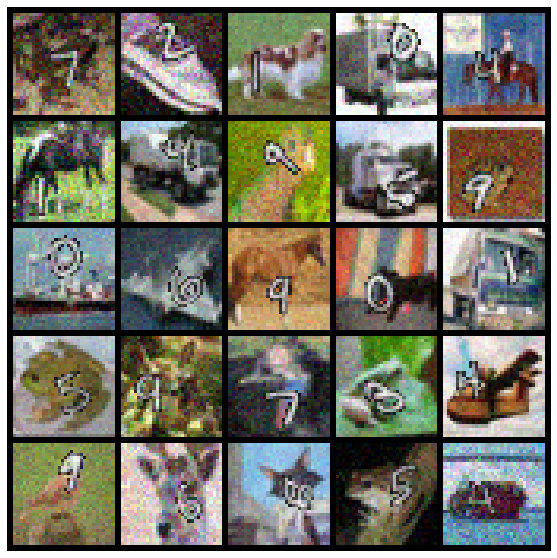


 Model architecture: ResNet9(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ResidualBlock(
      (conv_res1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_res1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (conv_res2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv_res2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (relu): ReLU()
    )

In [ ]:
if pathlib.Path(path_cmnist_test_loader).is_file():

    test_set = torch.load(path_cmnist_test_set)
    test_loader = torch.load(path_cmnist_test_loader)

else:
    '''
    # Load basis datasets.
    transform_mnist = transforms.Compose([transforms.Resize((16, 16)), transforms.ToTensor()])
    transform_cifar = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
    train_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
    test_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
    train_cifar = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
    test_cifar = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

    # Paste MNIST digits on CIFAR backgrounds, save as dictionaries.
    train_dict = save_cmnist_dict_disk(mnist=train_mnist, cifar=train_cifar, img_size=32, digit_size=16, rotate=[15, 15], noise=True, path_dict=path_cmnist_train_dict)
    test_dict = save_cmnist_dict_disk(mnist=test_mnist, cifar=test_cifar, img_size=32, digit_size=16, rotate=[15, 15], noise=True, path_dict=path_cmnist_test_dict)

    # Write dictionary to pickle file.
    with open(path_cmnist_train_dict, 'wb') as handle:
        pickle.dump(train_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(path_cmnist_test_dict, 'wb') as handle:
        pickle.dump(test_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Create sets and loaders with torch transforms.
    train_set = TransformCMNIST(path_dict=path_cmnist_train_dict, transform=None)
    test_set = TransformCMNIST(path_dict=path_cmnist_test_dict, transform=None)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle=False, num_workers=4)

    # Save loaders and sets.
    torch.save(train_set, path_cmnist_train_set)
    torch.save(test_set, path_cmnist_test_set)
    torch.save(train_loader, path_cmnist_train_loader)
    torch.save(test_loader, path_cmnist_test_loader)
    '''

# Load data and segmentation masks.
x_batch, y_batch = iter(test_loader).next()

# Plot data!
fig, ax = plt.subplots(figsize=(15, 10))
grid = torchvision.utils.make_grid(x_batch[:25], nrow=5)
ax.imshow(grid.numpy().transpose((1, 2, 0)))
ax.axis('off')
plt.show()

# Calculate segmentation masks.
s_batch =  np.array([[test_set.get_box(index).mean(axis=0).cpu().detach().numpy(), test_set.get_digit(index).mean(axis=0).cpu().detach().numpy(), test_set.get_area(index).mean(axis=0).cpu().detach().numpy()] for index in range(x_batch.shape[0])])
s_batch_box =  np.array([s[0] for s in s_batch])
s_batch_digit =  np.array([s[1] for s in s_batch])
s_batch_area =  np.array([s[2] for s in s_batch])

# Save model, x_batch, y_batch, s_batch to one dictionary.
assets = {'x_batch' : x_batch, 
            'y_batch': y_batch,
            's_batch': s_batch,
            's_batch_box': s_batch_box,
            's_batch_digit': s_batch_digit,
            's_batch_area':  s_batch_area}

np.save(path_cmnist_assets,  assets)

# Load model architecture.
model = ResNet9(nr_channels=3, nr_classes=10)
print(f"\n Model architecture: {model.eval()}\n")

# Set necessary configs/ parameters.
if pathlib.Path(path_cmnist_model).is_file():
    model.load_state_dict(torch.load(path_cmnist_model))
else: 
    model = train_model(model=model.to(device), 
                    train_loader=train_loader, 
                    test_loader=test_loader, 
                    criterion=torch.nn.CrossEntropyLoss(),
                    optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9), 
                    epochs=20,
                    path_model=path_cmnist_model, 
                    device=device)

In [ ]:
model = train_model(model=model.to(device), 
                    train_loader=train_loader, 
                    test_loader=test_loader, 
                    criterion=torch.nn.CrossEntropyLoss(),
                    optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9), 
                    epochs=20,
                    path_model=path_cmnist_model, 
                    device=device)

Epoch 1/20 - loss 0.11 - test accuracy: 97.11%
Epoch 2/20 - loss 0.08 - test accuracy: 97.15%
Epoch 3/20 - loss 0.00 - test accuracy: 97.44%
Epoch 4/20 - loss 0.00 - test accuracy: 98.00%
Epoch 5/20 - loss 0.01 - test accuracy: 97.50%
Epoch 6/20 - loss 0.00 - test accuracy: 97.70%
Epoch 7/20 - loss 0.02 - test accuracy: 97.27%
Epoch 8/20 - loss 0.00 - test accuracy: 97.24%
Epoch 9/20 - loss 0.00 - test accuracy: 97.86%
Epoch 10/20 - loss 0.01 - test accuracy: 97.87%
Epoch 11/20 - loss 0.00 - test accuracy: 98.04%
Epoch 12/20 - loss 0.00 - test accuracy: 97.94%
Epoch 13/20 - loss 0.00 - test accuracy: 97.95%
Epoch 14/20 - loss 0.00 - test accuracy: 98.16%
Epoch 15/20 - loss 0.00 - test accuracy: 98.10%
Epoch 16/20 - loss 0.00 - test accuracy: 98.10%
Epoch 17/20 - loss 0.00 - test accuracy: 98.18%
Epoch 18/20 - loss 0.00 - test accuracy: 98.00%
Epoch 19/20 - loss 0.00 - test accuracy: 98.01%
Epoch 20/20 - loss 0.00 - test accuracy: 98.09%


In [ ]:
# Example for how to reload assets and models to notebook.
model_cmnist = ResNet9(nr_channels=3, nr_classes=10)
model_cmnist.load_state_dict(torch.load(path_cmnist_model))

s_type = "box"

assets_cmnist = np.load(path_cmnist_assets, allow_pickle=True).item()
x_batch_cmnist = assets_cmnist["x_batch"]
y_batch_cmnist = assets_cmnist["y_batch"]
s_batch_cmnist = assets_cmnist[f"s_batch_{s_type}"]

### ImageNet

In [ ]:
path_imagenet_assets = path + "test_sets/imagenet_test_set.npy"
batch_size_test = 500

In [ ]:
# Get the labels as integers.

# Get the names of the folders.
folder_names = [f.split("/")[-1] for f in glob.glob("drive/MyDrive/Projects/imagenet_images/bboxes_images/*", recursive = True)] #folder_names = ["n01534433", "n02190166", "n02640242", "n02859443", "n02948072", "n03220513", "n03623198", "n04428191"]

# Map the class (string) to the class (integer), given a txt source converted to a mapping.
mapping_str = get_imagenet_str_labels(folder_names=folder_names, path="drive/MyDrive/Projects/")
mapping_int = get_imagenet_int_labels(path="drive/MyDrive/Projects/")

LABELS = get_labels(mapping_str=mapping_str, mapping_int=mapping_int)
print(LABELS)

[13, 96, 126, 292, 301, 308, 347, 387, 394, 405, 417, 426, 449, 470, 490, 516, 538, 615, 856]


In [ ]:
from captum.attr._core.gradient_shap import InputBaselineXGradient
from typing import List, Dict
import numpy as np
import torch
import os
import cv2
import PIL
from xml.etree import ElementTree
import xmltodict
import collections
from torchvision import transforms


def get_imagenet_int_labels(path: str = "/content/drive/MyDrive/Projects/quantus/tutorials/assets"):
    """Make a int-string label mapping for Imagenet classes."""
    mapping_int = {}
    with open(f'{path}imagenet_images/imagenet_labels.txt', 'r') as f:
        for ix, line in enumerate(f):
            if ix not in [0, 1001]:
                line = line.split('b" ')[0]
                key = line.split(':')[0]
                value = line.split(": '")[1].split("',\n")[0]
                mapping_int[int(key)] = str(value)

    return mapping_int


def get_imagenet_str_labels(folder_names: List[str],
                            path: str = "drive/MyDrive/Projects/quantus/tutorials/assets"):
    mapping_str = {}
    with open(path + "/imagenet_images/imagenet1000_clsid_to_labels.txt", "r") as f:
        lines = f.readlines()
        for l in lines:
            line_strings = l.split(":")
            c = str(line_strings[0])
            if c in folder_names:
                mapping_str[c] = str(line_strings[1][2:-3])

    return mapping_str


def get_labels(mapping_str: Dict[str, str], mapping_int: Dict[str, str]):
    labels = []
    for label_int, label_str_1 in mapping_int.items():
        for label_str, label_str_2 in mapping_str.items():
            if label_str_1 == label_str_2:
                labels.append(label_int)
    return labels

def load_sample_edit(path: str) -> dict:
    """Read data as image and path. """
    return {"input": PIL.Image.open(path).convert("RGB"), "path": path}


def load_binary_mask_edit(filename: str, path_data: str):
    """Load the binary mask for the given path of the data in the correct format. """
    binary_mask = {}

    filename = os.path.splitext(filename)[0]

    # Get label and file name.
    label = filename.split("/")[-2]
    fname = filename.split("_")[-1]

    # Parse annotations.
    full_fname_annotation = os.path.join(path_data, "Annotations/{}/{}_{}.xml".format(label, label, fname))
    full_fname_image = os.path.join(path_data, f"bboxes_images/{label}/{label}_{fname}.JPEG")

    if os.path.isfile(full_fname_image) and os.path.isfile(full_fname_annotation):
        #print(f"{full_fname_annotation} AND {full_fname_image} its a MATCH!!!!")

        tree = ElementTree.parse(full_fname_annotation)
        xml_data = tree.getroot()
        xmlstr = ElementTree.tostring(xml_data, encoding="utf-8", method="xml")
        annotation = dict(xmltodict.parse(xmlstr))['annotation']

        width = int(annotation["size"]["width"])
        height = int(annotation["size"]["height"])

        # Iterate objects.
        objects = annotation["object"]

        if type(objects) != list:
            mask = np.zeros((height, width), dtype=int)
            mask[int(objects['bndbox']['ymin']):int(objects['bndbox']['ymax']),
            int(objects['bndbox']['xmin']):int(objects['bndbox']['xmax'])] = 1
            binary_mask[objects['name']] = mask

        else:
            for object in annotation['object']:
                if type(object) == collections.OrderedDict:
                    if object['name'] in binary_mask.keys():
                        mask = binary_mask[object['name']]
                    else:
                        mask = np.zeros((height, width), dtype=np.uint8)

                    mask[int(object['bndbox']['ymin']):int(object['bndbox']['ymax']),
                    int(object['bndbox']['xmin']):int(object['bndbox']['xmax'])] = 1

                    binary_mask[object['name']] = mask

        # Preprocess binary masks to fit shape of image data.
        for key in binary_mask.keys():
            binary_mask[key] = cv2.resize(binary_mask[key],
                                          (224, 224),
                                          interpolation=cv2.INTER_NEAREST).astype(np.int)[:, :, np.newaxis]

        return binary_mask, label
    else:
        return None

class CustomTransformEdit(torch.nn.Module):
    """Custom transformation to handle image processing and binary mask processing simultaneously. """

    # Collect garbage.
    gc.collect()
    torch.cuda.empty_cache()
    
    image_transform = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def __init__(self, path):
        super().__init__()
        self.path = path

    def __call__(self, img, **kwargs):
        return {
            "image": self.image_transform(img["input"]),
            "mask_label": (load_binary_mask_edit(img["path"], self.path)),
            }

def CustomCollateEdit(batch):
    """Collate function to pack the image, mask and label data accordingly. """
    inputs = []
    targets = []
    masks = []
    
    LABELS = [13, 96, 126, 292, 301, 308, 347, 387, 394, 405, 417, 426, 449, 470, 490, 516, 538, 615, 856]
    
    #print(len(batch))
    for b in batch:
        # print(type(b[0]["mask"]), type(b), np.shape(b), b[1])#, LABELS[b[1]])
        if b[0]["mask_label"] is not None:
            mask = b[0]["mask_label"][0]#, b[0]["mask_label"][1]
            if len(mask) > 0:
                image = b[0]["image"]
                inputs.append(image)
                masks.append(mask)
                try:
                    #print("targets=ok -- label", label, b[1], LABELS[b[1]])
                    targets.append(LABELS[b[1]])
                except:
                    targets.append(None)

    # Collect garbage.
    gc.collect()
    torch.cuda.empty_cache()

    # Rearrange masks, inputs and targets.
    masks = torch.Tensor(np.array([m[list(m.keys())[0]][:, :, 0] for m in masks]))
    inputs = torch.stack(inputs, 0)
    targets = torch.tensor(targets)

    # Collect garbage.
    gc.collect()
    torch.cuda.empty_cache()

    return inputs, masks, targets


Processing batch 3 ... saving --> /content/drive/MyDrive/Projects/assets/test_sets/imagenet_test_set_2.npy 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


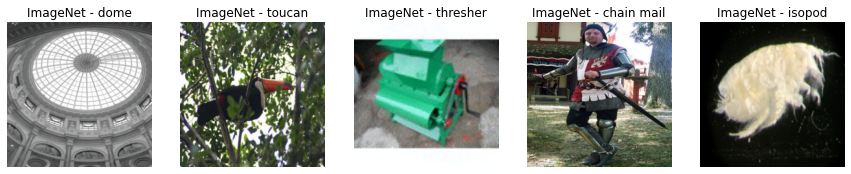

Length of batch 186
Processing batch 4 ... saving --> /content/drive/MyDrive/Projects/assets/test_sets/imagenet_test_set_3.npy 


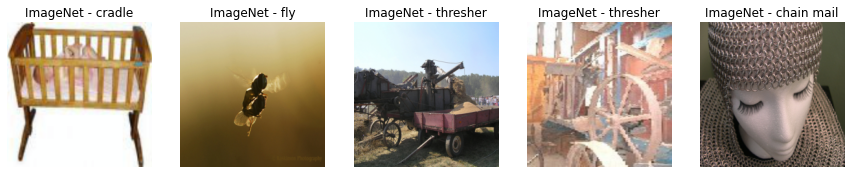

Length of batch 185
Processing batch 5 ... saving --> /content/drive/MyDrive/Projects/assets/test_sets/imagenet_test_set_4.npy 


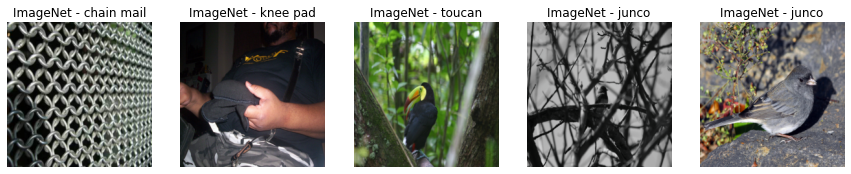

Length of batch 206
Processing batch 6 ... saving --> /content/drive/MyDrive/Projects/assets/test_sets/imagenet_test_set_5.npy 


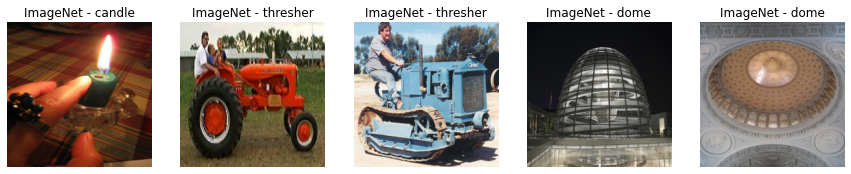

Length of batch 191
Processing batch 7 ... saving --> /content/drive/MyDrive/Projects/assets/test_sets/imagenet_test_set_6.npy 


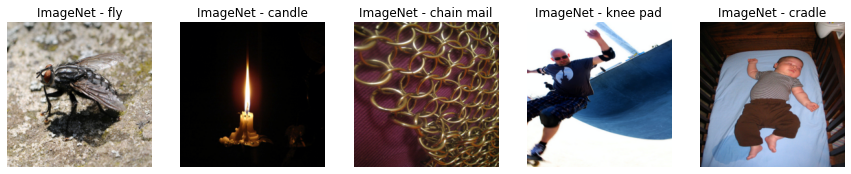

Length of batch 206
Processing batch 8 ... saving --> /content/drive/MyDrive/Projects/assets/test_sets/imagenet_test_set_7.npy 


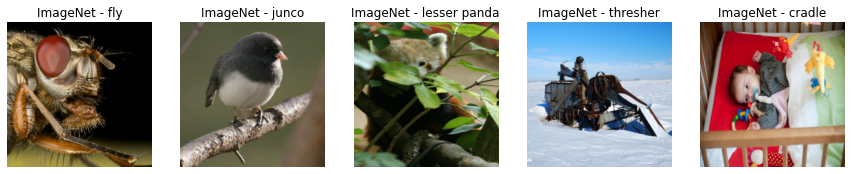

Length of batch 190


In [ ]:
for batch_i in range(8):

    #if batch_i < 2:
    #    continue

    path_imagenet_assets = path + f"test_sets/imagenet_test_set_{batch_i}.npy"

    print(f"Processing batch {int(batch_i+1)} ... saving --> {path_imagenet_assets} ")

    # Settings data.
    dataset = torchvision.datasets.DatasetFolder(os.path.join("drive/MyDrive/Projects/imagenet_images/", "bboxes_images/"),
                                                loader=load_sample_edit,
                                                extensions=(".jpeg", "png"),
                                                transform=CustomTransformEdit(path="drive/MyDrive/Projects/imagenet_images/")
                                                )
    test_loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size_test, collate_fn=CustomCollateEdit)

    # Load a batch of inputs, segmentation masks and outputs to use for evaluation.
    x_batch, s_batch, y_batch = iter(test_loader).next()
    x_batch, s_batch, y_batch = x_batch.cpu().numpy(), s_batch.cpu().numpy(), y_batch.cpu().numpy()
    plot_inputs(x_batch=x_batch, y_batch=y_batch, nr_images=5, img_size=224, name_dataset="ImageNet", 
                mapping=get_imagenet_int_labels("drive/MyDrive/Projects/"))

    # Collect garbage.
    gc.collect()
    torch.cuda.empty_cache()

    print(f"Length of batch {len(x_batch)}")

    # Save model, x_batch, y_batch, s_batch to one dictionary.
    assets = {'x_batch' : x_batch,
             'y_batch': y_batch,
             's_batch': s_batch}

    np.save(path_imagenet_assets,  assets) 



In [ ]:
path_imagenet_model = path + "models/imagenet_resnet18_model"
model = torchvision.models.resnet18(pretrained=True) 
torch.save(model.state_dict(), path_imagenet_model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
path_imagenet_model = path + "models/imagenet_vgg16_model"
model = torchvision.models.vgg16(pretrained=True) 
torch.save(model.state_dict(), path_imagenet_model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
path_imagenet_model = path + "models/imagenet_alexnet_model"
model = torchvision.models.alexnet(pretrained=True) 
torch.save(model.state_dict(), path_imagenet_model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
path_imagenet_model = path + "models/imagenet_mobilenet_v3_small_model"
model = torchvision.models.mobilenet_v3_small(pretrained=True) 
torch.save(model.state_dict(), path_imagenet_model)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

In [ ]:
path_imagenet_model = path + "models/imagenet_inception_v3_model"
model = torchvision.models.inception_v3(pretrained=True) 
torch.save(model.state_dict(), path_imagenet_model)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
for batch_i in range(8):
    
    path_imagenet_assets = path + f"test_sets/imagenet_test_set_{batch_i}.npy"
    
    assets_imagenet = np.load(path_imagenet_assets, allow_pickle=True).item()

    x_batch_imagenet = assets_imagenet["x_batch"]
    y_batch_imagenet = assets_imagenet["y_batch"]
    s_batch_imagenet = assets_imagenet["s_batch"]
    
    print(f"Length of batch {len(x_batch_imagenet)}")
    plot_inputs(x_batch=x_batch_imagenet, y_batch=y_batch_imagenet, nr_images=5, img_size=224, name_dataset="ImageNet", 
                mapping=get_imagenet_int_labels("drive/MyDrive/Projects/"))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Example for how to reload assets and models to notebook.
model_imagenet = torchvision.models.resnet18(pretrained=True) 

assets_imagenet = np.load(path_imagenet_assets, allow_pickle=True).item()
x_batch_imagenet = assets_imagenet["x_batch"]
y_batch_imagenet = assets_imagenet["y_batch"]
s_batch_imagenet = assets_imagenet["s_batch"]

In [ ]:
len(x_batch_imagenet)

190